# Parametric Nonlinear Programming (pNLP) with NeuroMANCER: Himmelblau's function

This is an interactive notebook based on the python script `mpNLP_Himmelblau_nm.py`. We demonstrate how the NeuroMANCER toolbox can be used to solve the [Himmelblau problem](https://en.wikipedia.org/wiki/Himmelblau%27s_function):

$$
\begin{align}
&\text{minimize } && (x^2 + y - 11)^2 + (x + y^2 - 7)^2\\
&\text{subject to} && \left(\frac{p}{2}\right)^2 \le x^2 + y^2 \le p^2\\
& && x \ge y
\end{align}
$$

with parameter $p$ and decision variables $x,y$.

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

We need to install a more recent version of matplotlib than is offered in the default Colab environment. After running the cell 1 for the first time in a new Colab runtime, you will see the prompt: "You must restart the runtime in order to use newly installed versions." After restarting, the correct version of matplotlib will be loaded for the duration of the current runtime.

In [ ]:
!pip install --upgrade matplotlib

In [ ]:
!pip install setuptools==61.0.0 casadi mlflow plum-dispatch
!pip install git+https://github.com/pnnl/neuromancer.git@master --ignore-requires-python --no-deps

### Import

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import numpy as np

import torch
import casadi
import time

from neuromancer import slim

In [3]:
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
import neuromancer.arg as arg
from neuromancer.constraint import variable
from neuromancer.activations import activations
from neuromancer.loggers import BasicLogger, MLFlowLogger
from neuromancer.dataset import get_static_dataloaders
from neuromancer.loss import PenaltyLoss
from neuromancer.solvers import GradientProjection
from neuromancer.maps import Map
from neuromancer import blocks

# Dataset

In [4]:
device = "cpu"
data_seed = 408  # random seed used for simulated data
np.random.seed(data_seed)
torch.manual_seed(data_seed);

Randomly sample parameters from a uniform distribution ($2\le p\le6$)

In [5]:
nsim = 20000  # number of datapoints: increase sample density for more robust results
samples = {"p": np.random.uniform(low=2.0, high=6.0, size=(nsim, 1))}
data, dims = get_static_dataloaders(samples)
train_data, dev_data, test_data = data

# pNLP Formulation in NeuroMANCER

## Primal Solution Map Architecture

In [6]:
n_layers = 4    # number of hidden layers
nx_hidden = 80  # hidden layer size

In [7]:
func = blocks.MLP(insize=1, outsize=2,
                bias=True,
                linear_map=slim.maps['linear'],
                nonlin=activations['relu'],
                hsizes=[nx_hidden] * n_layers)
sol_map = Map(func,
        input_keys=["p"],
        output_keys=["x"],
        name='primal_map')

## Objective and Constraints

In [8]:
Q = 1.0            # loss function weight
Q_con = 100.0      # constraints penalty weight
proj_grad = False  # whether or not to use projected gradient update

In [9]:
# variables
x = variable("x")[:, [0]]
y = variable("x")[:, [1]]
# sampled parameters
p = variable('p')

# objective function
f = (x**2 + y - 11)**2 + (x + y**2 - 7)**2
obj = f.minimize(weight=Q, name='obj')

# constraints
con_1 = (x >= y)
con_2 = ((p/2)**2 <= x**2+y**2)
con_3 = (x**2+y**2 <= p**2)
con_1.name = 'c1'
con_2.name = 'c2'
con_3.name = 'c3'

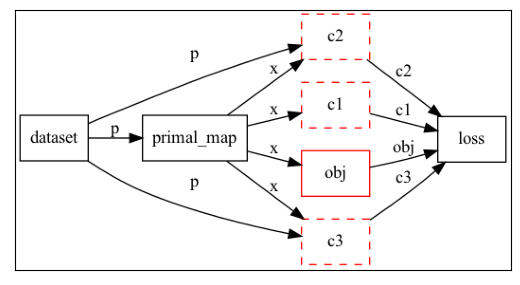

In [10]:
# constrained optimization problem construction
objectives = [obj]
constraints = [Q_con*con_1, Q_con*con_2, Q_con*con_3]
components = [sol_map]

if proj_grad:  # use projected gradient update
    project_keys = ["x"]
    projection = GradientProjection(constraints, input_keys=project_keys,
                                    num_steps=5, name='proj')
    components.append(projection)

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss, grad_inference=proj_grad)
# plot computational graph
problem.plot_graph()

## Problem Solution

In [11]:
# selected parameters
p = 4.0

### Train Solution Map

In [12]:
lr = 0.001      # step size for gradient descent
epochs = 300    # number of training epochs
warmup = 100    # number of epochs to wait before enacting early stopping policy
patience = 100  # number of epochs with no improvement in eval metric to allow 
                #   before early stopping

In [13]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)

# define trainer
trainer = Trainer(
    problem,
    train_data,
    dev_data,
    test_data,
    optimizer,
    epochs=epochs,
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="test_loss",
    eval_metric="dev_loss",
    patience=patience,
    warmup=warmup,
    device=device,
)

In [14]:
# Train NLP solution map
best_model = trainer.train()
best_outputs = trainer.test(best_model)
# load best model dict
problem.load_state_dict(best_model)

epoch: 0  train_loss: 66.01835632324219
epoch: 1  train_loss: 18.267681121826172
epoch: 2  train_loss: 16.60422706604004
epoch: 3  train_loss: 16.972389221191406
epoch: 4  train_loss: 16.419897079467773
epoch: 5  train_loss: 15.013101577758789
epoch: 6  train_loss: 14.295248031616211
epoch: 7  train_loss: 14.071354866027832
epoch: 8  train_loss: 15.46351432800293
epoch: 9  train_loss: 14.903855323791504
epoch: 10  train_loss: 14.18571949005127
epoch: 11  train_loss: 13.981148719787598
epoch: 12  train_loss: 15.063672065734863
epoch: 13  train_loss: 13.5791654586792
epoch: 14  train_loss: 13.421749114990234
epoch: 15  train_loss: 13.058341026306152
epoch: 16  train_loss: 13.265741348266602
epoch: 17  train_loss: 12.7937593460083
epoch: 18  train_loss: 13.40497875213623
epoch: 19  train_loss: 12.862196922302246
epoch: 20  train_loss: 13.540416717529297
epoch: 21  train_loss: 12.838932991027832
epoch: 22  train_loss: 12.569019317626953
epoch: 23  train_loss: 12.82066535949707
epoch: 24  t

epoch: 194  train_loss: 11.199142456054688
epoch: 195  train_loss: 10.73564338684082
epoch: 196  train_loss: 11.504364967346191
epoch: 197  train_loss: 10.951935768127441
epoch: 198  train_loss: 10.655009269714355
epoch: 199  train_loss: 10.6611967086792
epoch: 200  train_loss: 11.118833541870117
epoch: 201  train_loss: 10.754253387451172
epoch: 202  train_loss: 10.962060928344727
epoch: 203  train_loss: 11.176526069641113
epoch: 204  train_loss: 10.818113327026367
epoch: 205  train_loss: 11.05953598022461
epoch: 206  train_loss: 10.887459754943848
epoch: 207  train_loss: 10.829426765441895
epoch: 208  train_loss: 11.114792823791504
epoch: 209  train_loss: 11.071643829345703
epoch: 210  train_loss: 10.81649112701416
epoch: 211  train_loss: 10.832691192626953
epoch: 212  train_loss: 10.85580825805664
epoch: 213  train_loss: 11.102055549621582
epoch: 214  train_loss: 10.79837703704834
epoch: 215  train_loss: 11.097498893737793
epoch: 216  train_loss: 10.8859224319458
epoch: 217  train_lo

<All keys matched successfully>

### Solve

In [15]:
# Solution to mpNLP via Neuromancer
datapoint = {}
datapoint['p'] = torch.tensor([[p]])
datapoint['name'] = "test"
model_out = problem(datapoint)
x_nm = model_out['test_' + "x"][0, 0].detach().numpy()
y_nm = model_out['test_' + "x"][0, 1].detach().numpy()
print(f"x = {x_nm}")
print(f"y = {y_nm}")

x = 3.0086474418640137
y = 2.005309581756592


# pNLP Formulation in CasADi

[CasADi](https://web.casadi.org/) is an open-source tool for constrained optimization and optimal control that has influenced the development of NeuroMANCER.

## Optimization Problem

In [16]:
# instantiate casadi optimization problem class
def NLP_param(p, opti_silent=False):
    opti = casadi.Opti()
    # define variables
    x = opti.variable()
    y = opti.variable()
    p_opti = opti.parameter()
    # define objective and constraints
    opti.minimize((x**2 + y - 11)**2 + (x + y**2 - 7)**2)
    opti.subject_to(x >= y)
    opti.subject_to((p_opti / 2) ** 2 <= x ** 2 + y ** 2)
    opti.subject_to(x ** 2 + y ** 2 <= p_opti ** 2)
    # select IPOPT solver and solve the NLP
    if opti_silent:
        opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
    else:
        opts = {}
    opti.solver('ipopt', opts)
    # set parametric values
    opti.set_value(p_opti, p)
    return opti, x, y

# construct casadi problem
opti, x, y = NLP_param(p)

## Problem Solution

In [17]:
# solve pNLP via casadi
sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

In [18]:
print(f"x = {sol.value(x)}")
print(f"y = {sol.value(y)}")

x = 3.0000000000313176
y = 1.9999999998423519


# Benchmark: NeuroMANCER vs. CasADi

## Plot solutions

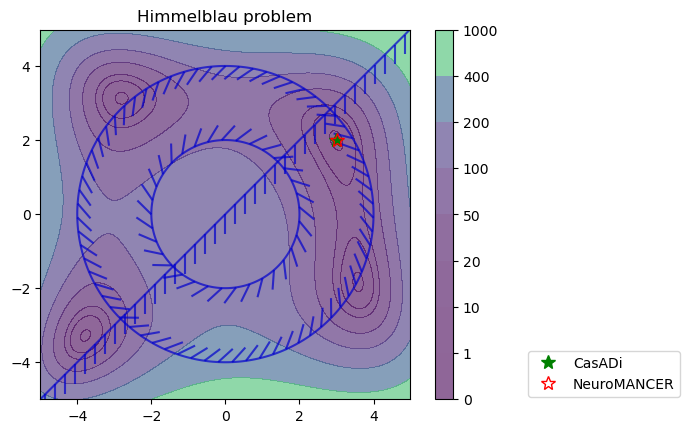

In [19]:
x1 = np.arange(-5.0, 5.0, 0.02)
y1 = np.arange(-5.0, 5.0, 0.02)
xx, yy = np.meshgrid(x1, y1)

# eval objective and constraints
J = (xx**2 + yy - 11)**2 + (xx + yy**2 - 7)**2
c1 = xx - yy
c2 = xx ** 2 + yy ** 2 - (p / 2) ** 2
c3 = -(xx ** 2 + yy ** 2) + p ** 2

levels = [0, 1.0, 10.0, 20., 50., 100., 200., 400., 1000.]
fig, ax = plt.subplots()
cp = ax.contourf(xx, yy, J, levels=levels, alpha=0.6)

fig.colorbar(cp)
ax.set_title('Himmelblau problem')
cg1 = ax.contour(xx, yy, c1, [0], colors='mediumblue', alpha=0.7)
plt.setp(cg1.collections,
         path_effects=[patheffects.withTickedStroke()], alpha=0.7)
cg2 = ax.contour(xx, yy, c2, [0], colors='mediumblue', alpha=0.7)
plt.setp(cg2.collections,
         path_effects=[patheffects.withTickedStroke()], alpha=0.7)
cg3 = ax.contour(xx, yy, c3, [0], colors='mediumblue', alpha=0.7)
plt.setp(cg3.collections,
         path_effects=[patheffects.withTickedStroke()], alpha=0.7)
ax.set_aspect('equal')

# optimal points CasADi vs Neuromancer
ax.plot(sol.value(x), sol.value(y), 'g*', markersize=10, label='CasADi')
ax.plot(x_nm, y_nm, 'r*',fillstyle='none', markersize=10, label='NeuroMANCER')

plt.legend(bbox_to_anchor=(1.75,0.15));

In [20]:
def eval_constraints(x, y, p):
    """
    evaluate mean constraints violations
    """
    con_1_viol = np.maximum(0, y - x)
    con_2_viol = np.maximum(0, (p/2)**2 - (x**2+y**2))
    con_3_viol = np.maximum(0, x**2+y**2 - p**2)
    con_viol = con_1_viol + con_2_viol + con_3_viol
    con_viol_mean = np.mean(con_viol)
    return con_viol_mean

def eval_objective(x, y):
    obj_value_mean = np.mean((x**2 + y - 11)**2 + (x + y**2 - 7)**2)
    return obj_value_mean

# select n number of random samples to evaluate
n_samples = 1000
idx = np.random.randint(0, nsim, n_samples)
p = samples['p'][idx]

In [21]:
# create named dictionary for neuromancer
datapoint = {}
datapoint['p'] = torch.tensor(p).float()
datapoint['name'] = "test"

# Solve via neuromancer
t = time.time()
model_out = problem(datapoint)
nm_time = time.time() - t
x_nm = model_out['test_' + "x"][:, [0]].detach().numpy()
y_nm = model_out['test_' + "x"][:, [1]].detach().numpy()

In [22]:
# Solve via solver
t = time.time()
x_solver, y_solver = [], []
for i in range(0, n_samples):
    prob, x, y = NLP_param(p[i], opti_silent=True)
    sol = prob.solve()
    x_solver.append(sol.value(x))
    y_solver.append(sol.value(y))
solver_time = time.time() - t
x_solver = np.asarray(x_solver)
y_solver = np.asarray(y_solver)

In [23]:
# Evaluate neuromancer solution
print(f'Solution for {n_samples} problems via Neuromancer obtained in {nm_time:.4f} seconds')
nm_con_viol_mean = eval_constraints(x_nm, y_nm, p)
print(f'Neuromancer mean constraints violation {nm_con_viol_mean:.4f}')
nm_obj_mean = eval_objective(x_nm, y_nm)
print(f'Neuromancer mean objective value {nm_obj_mean:.4f}\n')

# Evaluate solver solution
print(f'Solution for {n_samples} problems via solver obtained in {solver_time:.4f} seconds')
solver_con_viol_mean = eval_constraints(x_solver, y_solver, p)
print(f'Solver mean constraints violation {solver_con_viol_mean:.4f}')
solver_obj_mean = eval_objective(x_solver, y_solver)
print(f'Solver mean objective value {solver_obj_mean:.4f}\n')

# neuromancer solver comparison
speedup_factor = solver_time/nm_time
print(f'Solution speedup factor {speedup_factor:.4f}')

# Difference in primal optimizers
dx = (x_solver - x_nm)[:,0]
dy = (y_solver - y_nm)[:,0]
err_x = np.mean(dx**2)
err_y = np.mean(dy**2)
err_primal = err_x + err_y
print('MSE primal optimizers:', err_primal)

# Difference in objective
err_obj = np.abs(solver_obj_mean - nm_obj_mean) / solver_obj_mean * 100
print(f'mean objective value discrepancy: {err_obj:.2f} %')

Solution for 1000 problems via Neuromancer obtained in 0.0019 seconds
Neuromancer mean constraints violation 0.0061
Neuromancer mean objective value 10.0506

Solution for 1000 problems via solver obtained in 5.6638 seconds
Solver mean constraints violation 1.5400
Solver mean objective value 10.1074

Solution speedup factor 3020.7986
MSE primal optimizers: 0.3759167515191977
mean objective value discrepancy: 0.56 %
